In [2]:
import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from helper_plot import hdr_plot_style
hdr_plot_style()

In [32]:
def save_model(model,path):
    """ 
    Inputs : 
    path : str
        Path and name of the model you want to save
    """
    choice = input("Do you want to save your model ?")
    if choice == "Yes":
        torch.save(model.state_dict(), path)
    print(f"Model save as {path}")

import os
def load_model(var_name,path_name):
    """ 
    Inputs : 
    var_name : str
        Name under witch you want to load the model

    path_name : str
        Name of the file you want to load

    Return :
    var_name : model 
    """
    if os.path.isfile(path_name):
        var_name.load_state_dict(torch.load(path_name))
    else :
        print("File not found")


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

---
Définition de l'auto encodeur que nous allons utiliser

In [4]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, encoding_dim):
        super(AE, self).__init__()
        self.encoding_dims = encoding_dim
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

--- 
Définition du VAE qui va utiliser cet auto encodeur

In [5]:
class VAE(AE):
    
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(VAE, self).__init__(encoder, decoder, encoding_dims)
        self.latent_dims = latent_dims
        self.mu = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims))
        self.sigma = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.Softplus())
        
    def encode(self, x):
        
        x = self.encoder(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        
        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(x, z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde.reshape(-1, 1, 28, 28), kl_div
    
    def latent(self, x, z_params):
        
        mu, sigma = z_params

        var = sigma * sigma
        log_var = torch.log(var)

        z = torch.rand_like(mu) * sigma + mu
        kl_div = torch.sum(mu * mu + var - log_var - 1)

        return z, kl_div

--- 
La structure du VAE est donc en place, il nous reste à implémenter l'encodeur et le décodeur de notre algo

In [6]:
def construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
          nn.Flatten(),
          nn.Linear(nin, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
    )
    # Decoder network
    decoder = nn.Sequential(
          nn.Linear(n_latent, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, nin * n_classes), nn.Sigmoid()
    )
    return encoder, decoder

### Evaluating the error

In the definition of the `VAE` class, we directly included the computation of the $D_{KL}$ term to regularize our latent space. However, remember that the complete loss of equation (4) also contains a *reconstruction loss* which compares our reconstructed output to the original data. 

While there are several options to compare the error between two elements, there are usually two preferred choices among the generative literature depending on how we consider our problem
1. If we consider each dimension (pixel) to be a binary unit (following a Bernoulli distribution), we can rely on the `binary cross entropy` between the two distributions
2. If we turn our problem to a set of classifications, where each dimension can belong to a given set of *intensity classes*, then we can compute the `multinomial loss` between the two distributions

In the following, we define both error functions and regroup them in the `reconstruction_loss` call (depending on the `num_classes` considered). However, as the `multinomial loss` requires a large computational overhead, and for the sake of simplicity, we will train all our first models by relying on the `binary cross entropy`

In [7]:
# Reconstruction criterion
recons_criterion = torch.nn.BCELoss(reduction='sum')

def compute_loss(model, x):
        
    beta = 0.1
    y_pred,kl_div = model(x)
    recons_loss = recons_criterion(y_pred, x)
    full_loss = recons_loss + kl_div*beta
    #print(kl_div,recons_loss,full_loss)
    
    return full_loss,kl_div,recons_loss

def train_step(model, x, optimizer):
    #model = model.to(device)
    #x = x.to(device)
    # Compute the loss.
    loss,kl_div,recons_loss = compute_loss(model, x)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    return loss,kl_div,recons_loss

### Optimizing a VAE on a real dataset

For this tutorial, we are going to take a quick shot at a real-life problem by trying to train our VAEs on the `FashionMNIST` dataset. This dataset can be natively used in PyTorch by relying on the `torchvision.datasets` classes as follows

In [8]:
dataset_dir = './data'
# Going to use 80%/20% split for train/valid
valid_ratio = 0.2
# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.MNIST(root=dataset_dir, train=True, transform=torchvision.transforms.ToTensor(), download=True)
# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
# Load the test set
test_dataset = torchvision.datasets.MNIST(root=dataset_dir, transform=torchvision.transforms.ToTensor(),train=False)
# Prepare 
num_threads = 0     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

The `FashionMNIST` dataset is composed of simple 28x28 black and white images of different items of clothings (such as shoes, bags, pants and shirts). We put a simple function here to display one batch of the test set (note that we keep a fixed batch from the test set in order to evaluate the different variations that we will try in this tutorial).

The train set contains 48000 images, in 375 batches
The validation set contains 12000 images, in 94 batches
The test set contains 10000 images, in 79 batches


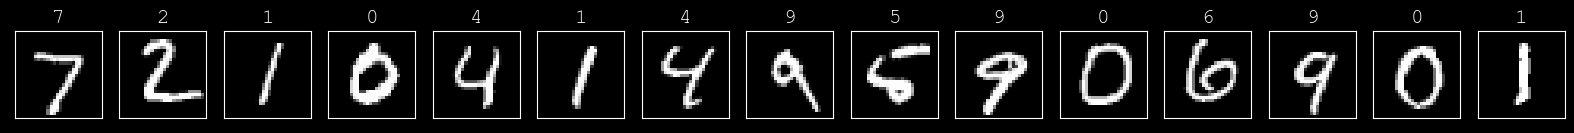

In [9]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))
nsamples = 15
classes_names = ['0','1', '2', '3', '4', '5', '6','7', '8', '9']
imgs_test, labels = next(iter(test_loader))
fig = plt.figure(figsize=(20,5))
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs_test[i, 0, :, :], vmin=0, vmax=1.0, cmap=matplotlib.cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Now based on our proposed implementation, the optimization aspects are defined in a very usual way

In [10]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Compute input dimensionality
nin = imgs_test.shape[2] * imgs_test.shape[3]
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
encoder = encoder
decoder = decoder
# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent)
# Construct the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Now all that is left to do is train the model. We define here a `train_vae` function that we will reuse along the future implementations and variations of VAEs and flows. Note that this function is set to run for only a very few number of `epochs` and also most importantly, *only considers a subsample of the full dataset at each epoch*. This option is just here so that you can test the different models very quickly on any CPU or laptop.

In [11]:
def generate_and_save_images(model, epoch, test_sample):
    #model = model.to(device)
    #test_sample = test_sample.to(device)
    predictions, _ = model(test_sample)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, 0, :, :].detach().cpu(), cmap='gray')
        plt.axis('off')
    # Tight_layout minimizes the overlap between 2 sub-plots
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

epochs=50
test_sample = imgs_test[0:16, :, :, :]
def train_vae(model, epochs,repres_sample):
    for epoch in range(1, epochs + 1):
        full_loss = torch.Tensor([0])
        kl_div = torch.Tensor([0])
        recons_loss = torch.Tensor([0])
        # Forward pass: compute predicted y by passing x to the model.
        for i, (x, _) in enumerate(train_loader):
            #x=x.to(device)
            #model=model.to(device)
            full_loss_add,kl_div_add,recons_loss_add = train_step(model, x, optimizer)
            full_loss += full_loss_add
            kl_div += kl_div_add
            recons_loss += recons_loss_add
            
        #for i, (x, _) in enumerate(valid_loader):
        #    train_step(model, x, optimizer)
        print('Epoch: {}, Test set ELBO: {}, Kl : {}, recons :{}'.format(epoch, full_loss,kl_div,recons_loss))
        generate_and_save_images(model, epoch, repres_sample)

Epoch: 1, Test set ELBO: tensor([11149703.], grad_fn=<AddBackward0>), Kl : tensor([850940.0625], grad_fn=<AddBackward0>), recons :tensor([11064605.], grad_fn=<AddBackward0>)


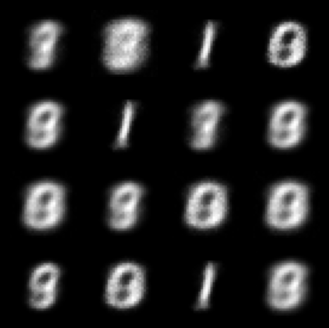

Epoch: 2, Test set ELBO: tensor([8506175.], grad_fn=<AddBackward0>), Kl : tensor([682423.8750], grad_fn=<AddBackward0>), recons :tensor([8437929.], grad_fn=<AddBackward0>)


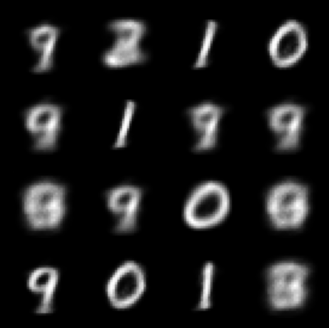

Epoch: 3, Test set ELBO: tensor([7969224.], grad_fn=<AddBackward0>), Kl : tensor([641424.0625], grad_fn=<AddBackward0>), recons :tensor([7905084.5000], grad_fn=<AddBackward0>)


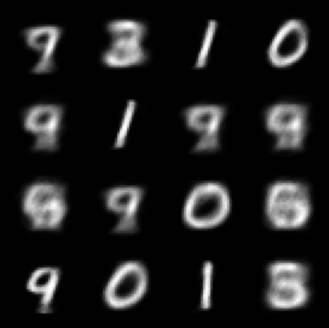

Epoch: 4, Test set ELBO: tensor([7703056.], grad_fn=<AddBackward0>), Kl : tensor([679384.6875], grad_fn=<AddBackward0>), recons :tensor([7635117.5000], grad_fn=<AddBackward0>)


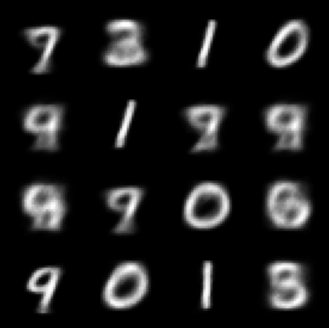

Epoch: 5, Test set ELBO: tensor([7541657.], grad_fn=<AddBackward0>), Kl : tensor([692366.0625], grad_fn=<AddBackward0>), recons :tensor([7472420.], grad_fn=<AddBackward0>)


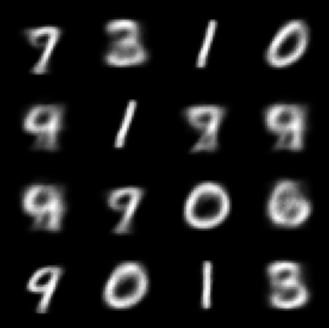

Epoch: 6, Test set ELBO: tensor([7427746.], grad_fn=<AddBackward0>), Kl : tensor([694369.8125], grad_fn=<AddBackward0>), recons :tensor([7358311.], grad_fn=<AddBackward0>)


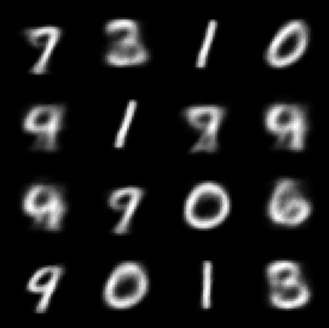

Epoch: 7, Test set ELBO: tensor([7338100.5000], grad_fn=<AddBackward0>), Kl : tensor([692388.], grad_fn=<AddBackward0>), recons :tensor([7268861.5000], grad_fn=<AddBackward0>)


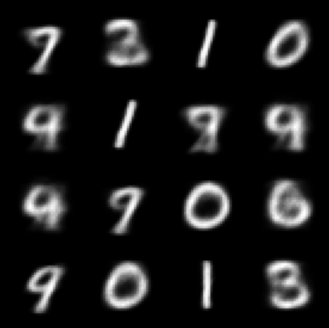

Epoch: 8, Test set ELBO: tensor([7263620.], grad_fn=<AddBackward0>), Kl : tensor([690803.], grad_fn=<AddBackward0>), recons :tensor([7194536.5000], grad_fn=<AddBackward0>)


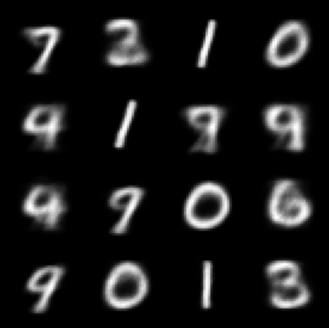

Epoch: 9, Test set ELBO: tensor([7198171.5000], grad_fn=<AddBackward0>), Kl : tensor([687637.3750], grad_fn=<AddBackward0>), recons :tensor([7129410.5000], grad_fn=<AddBackward0>)


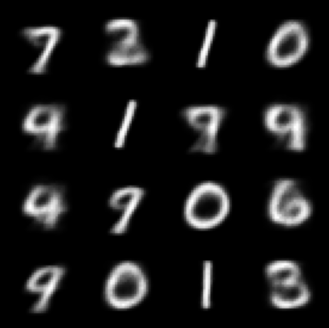

Epoch: 10, Test set ELBO: tensor([7142046.], grad_fn=<AddBackward0>), Kl : tensor([688087.3125], grad_fn=<AddBackward0>), recons :tensor([7073237.], grad_fn=<AddBackward0>)


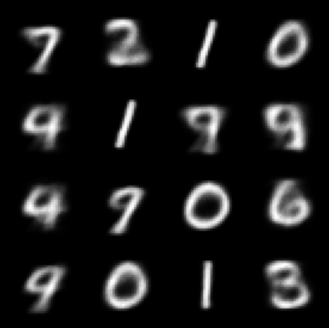

Epoch: 11, Test set ELBO: tensor([7087399.], grad_fn=<AddBackward0>), Kl : tensor([687809.0625], grad_fn=<AddBackward0>), recons :tensor([7018616.], grad_fn=<AddBackward0>)


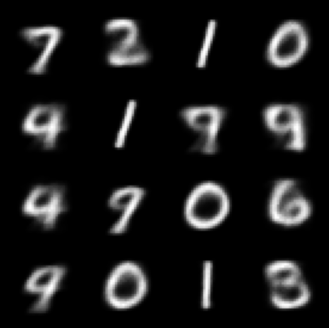

Epoch: 12, Test set ELBO: tensor([7040720.], grad_fn=<AddBackward0>), Kl : tensor([686764.0625], grad_fn=<AddBackward0>), recons :tensor([6972044.5000], grad_fn=<AddBackward0>)


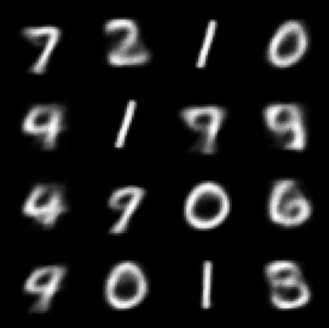

Epoch: 13, Test set ELBO: tensor([6992583.], grad_fn=<AddBackward0>), Kl : tensor([686882.], grad_fn=<AddBackward0>), recons :tensor([6923895.], grad_fn=<AddBackward0>)


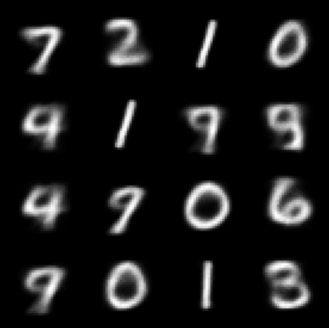

Epoch: 14, Test set ELBO: tensor([6951457.5000], grad_fn=<AddBackward0>), Kl : tensor([687307.7500], grad_fn=<AddBackward0>), recons :tensor([6882725.5000], grad_fn=<AddBackward0>)


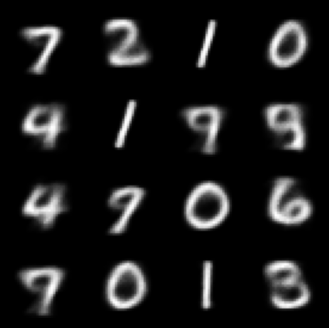

Epoch: 15, Test set ELBO: tensor([6911184.], grad_fn=<AddBackward0>), Kl : tensor([685897.9375], grad_fn=<AddBackward0>), recons :tensor([6842593.5000], grad_fn=<AddBackward0>)


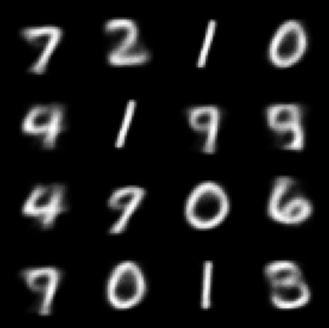

Epoch: 16, Test set ELBO: tensor([6874667.], grad_fn=<AddBackward0>), Kl : tensor([687052.1250], grad_fn=<AddBackward0>), recons :tensor([6805961.], grad_fn=<AddBackward0>)


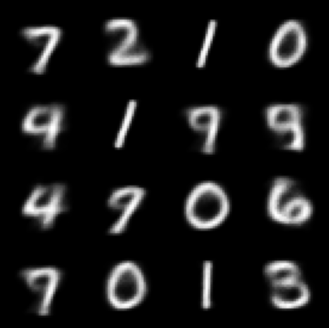

Epoch: 17, Test set ELBO: tensor([6842873.], grad_fn=<AddBackward0>), Kl : tensor([685872.3125], grad_fn=<AddBackward0>), recons :tensor([6774289.], grad_fn=<AddBackward0>)


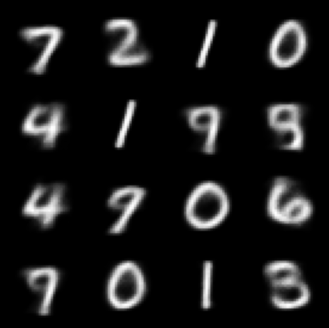

Epoch: 18, Test set ELBO: tensor([6815677.], grad_fn=<AddBackward0>), Kl : tensor([683208.5625], grad_fn=<AddBackward0>), recons :tensor([6747357.5000], grad_fn=<AddBackward0>)


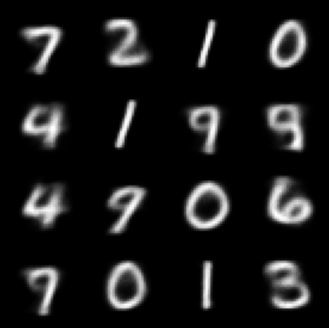

Epoch: 19, Test set ELBO: tensor([6793370.], grad_fn=<AddBackward0>), Kl : tensor([678958.4375], grad_fn=<AddBackward0>), recons :tensor([6725473.], grad_fn=<AddBackward0>)


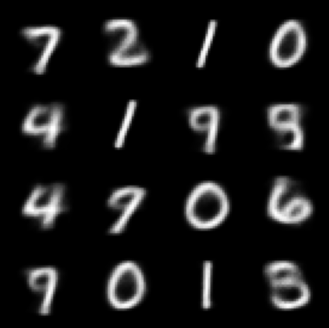

Epoch: 20, Test set ELBO: tensor([6766609.], grad_fn=<AddBackward0>), Kl : tensor([677950.3125], grad_fn=<AddBackward0>), recons :tensor([6698816.], grad_fn=<AddBackward0>)


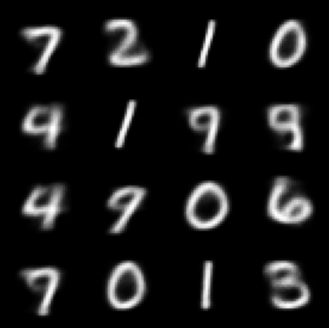

Epoch: 21, Test set ELBO: tensor([6744564.5000], grad_fn=<AddBackward0>), Kl : tensor([679471.2500], grad_fn=<AddBackward0>), recons :tensor([6676616.5000], grad_fn=<AddBackward0>)


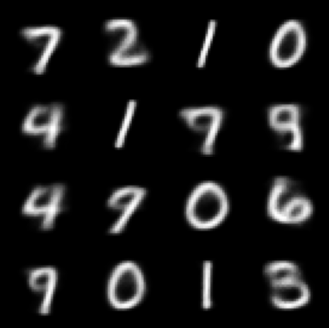

Epoch: 22, Test set ELBO: tensor([6726074.5000], grad_fn=<AddBackward0>), Kl : tensor([676468.1875], grad_fn=<AddBackward0>), recons :tensor([6658425.5000], grad_fn=<AddBackward0>)


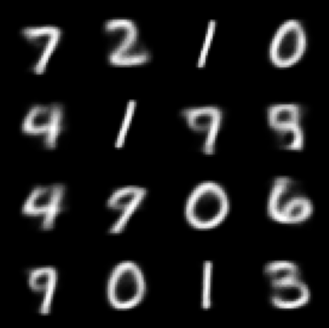

Epoch: 23, Test set ELBO: tensor([6706874.5000], grad_fn=<AddBackward0>), Kl : tensor([676574.6250], grad_fn=<AddBackward0>), recons :tensor([6639213.5000], grad_fn=<AddBackward0>)


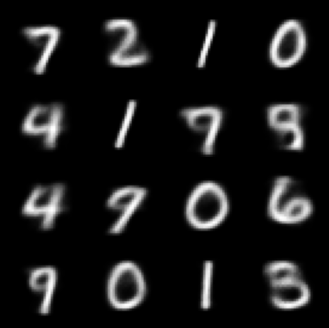

Epoch: 24, Test set ELBO: tensor([6693519.5000], grad_fn=<AddBackward0>), Kl : tensor([673882.1250], grad_fn=<AddBackward0>), recons :tensor([6626135.], grad_fn=<AddBackward0>)


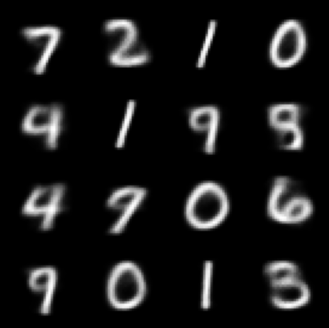

Epoch: 25, Test set ELBO: tensor([6672489.], grad_fn=<AddBackward0>), Kl : tensor([675301.1875], grad_fn=<AddBackward0>), recons :tensor([6604956.5000], grad_fn=<AddBackward0>)


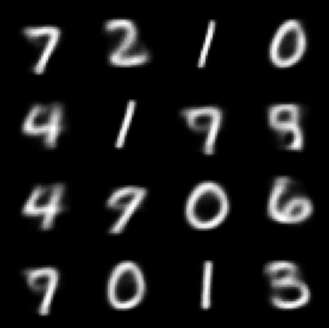

Epoch: 26, Test set ELBO: tensor([6662431.], grad_fn=<AddBackward0>), Kl : tensor([673025.4375], grad_fn=<AddBackward0>), recons :tensor([6595127.], grad_fn=<AddBackward0>)


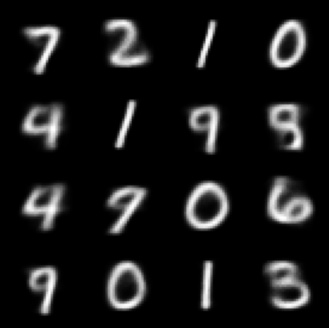

Epoch: 27, Test set ELBO: tensor([6644906.], grad_fn=<AddBackward0>), Kl : tensor([672011.7500], grad_fn=<AddBackward0>), recons :tensor([6577706.5000], grad_fn=<AddBackward0>)


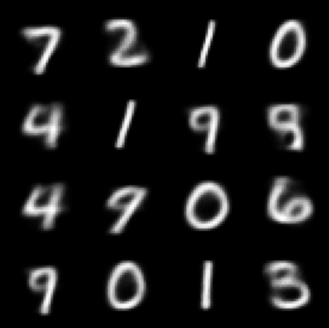

Epoch: 28, Test set ELBO: tensor([6625701.], grad_fn=<AddBackward0>), Kl : tensor([672356.6250], grad_fn=<AddBackward0>), recons :tensor([6558464.], grad_fn=<AddBackward0>)


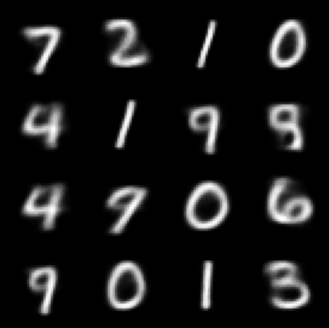

Epoch: 29, Test set ELBO: tensor([6613402.5000], grad_fn=<AddBackward0>), Kl : tensor([671757.5625], grad_fn=<AddBackward0>), recons :tensor([6546225.5000], grad_fn=<AddBackward0>)


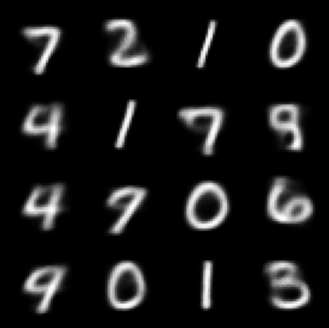

Epoch: 30, Test set ELBO: tensor([6606121.], grad_fn=<AddBackward0>), Kl : tensor([669636.5625], grad_fn=<AddBackward0>), recons :tensor([6539157.5000], grad_fn=<AddBackward0>)


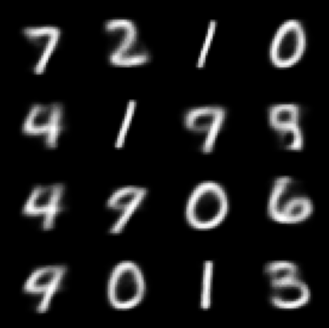

Epoch: 31, Test set ELBO: tensor([6591016.], grad_fn=<AddBackward0>), Kl : tensor([670618.2500], grad_fn=<AddBackward0>), recons :tensor([6523950.], grad_fn=<AddBackward0>)


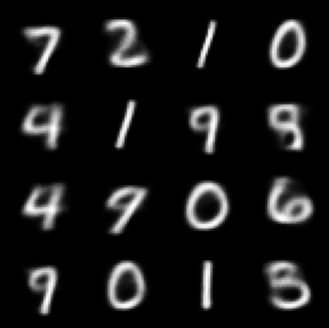

Epoch: 32, Test set ELBO: tensor([6583806.5000], grad_fn=<AddBackward0>), Kl : tensor([669927.8125], grad_fn=<AddBackward0>), recons :tensor([6516815.5000], grad_fn=<AddBackward0>)


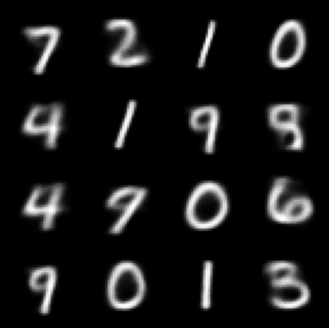

Epoch: 33, Test set ELBO: tensor([6577494.5000], grad_fn=<AddBackward0>), Kl : tensor([667185.6250], grad_fn=<AddBackward0>), recons :tensor([6510773.], grad_fn=<AddBackward0>)


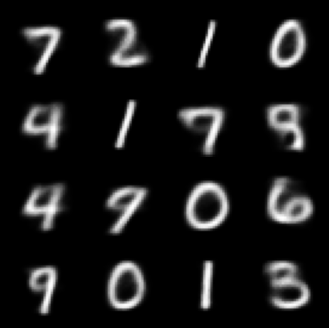

Epoch: 34, Test set ELBO: tensor([6566302.], grad_fn=<AddBackward0>), Kl : tensor([666662.], grad_fn=<AddBackward0>), recons :tensor([6499637.5000], grad_fn=<AddBackward0>)


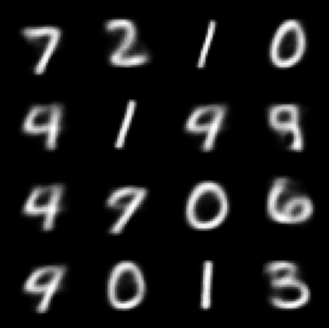

Epoch: 35, Test set ELBO: tensor([6564664.5000], grad_fn=<AddBackward0>), Kl : tensor([666263.8750], grad_fn=<AddBackward0>), recons :tensor([6498042.5000], grad_fn=<AddBackward0>)


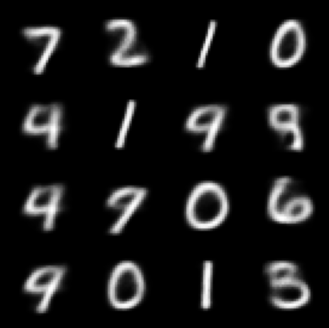

Epoch: 36, Test set ELBO: tensor([6551157.5000], grad_fn=<AddBackward0>), Kl : tensor([667375.6250], grad_fn=<AddBackward0>), recons :tensor([6484421.], grad_fn=<AddBackward0>)


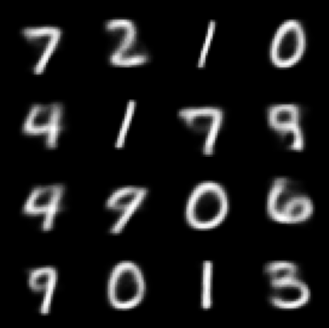

Epoch: 37, Test set ELBO: tensor([6538943.5000], grad_fn=<AddBackward0>), Kl : tensor([666207.4375], grad_fn=<AddBackward0>), recons :tensor([6472320.], grad_fn=<AddBackward0>)


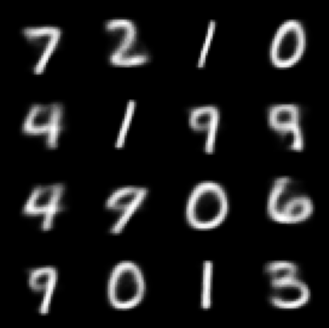

Epoch: 38, Test set ELBO: tensor([6523027.5000], grad_fn=<AddBackward0>), Kl : tensor([667507.6250], grad_fn=<AddBackward0>), recons :tensor([6456273.5000], grad_fn=<AddBackward0>)


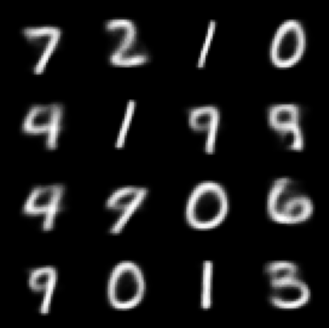

Epoch: 39, Test set ELBO: tensor([6513196.5000], grad_fn=<AddBackward0>), Kl : tensor([669437.6875], grad_fn=<AddBackward0>), recons :tensor([6446258.5000], grad_fn=<AddBackward0>)


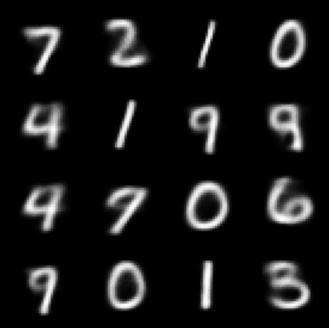

Epoch: 40, Test set ELBO: tensor([6507696.], grad_fn=<AddBackward0>), Kl : tensor([669292.], grad_fn=<AddBackward0>), recons :tensor([6440768.], grad_fn=<AddBackward0>)


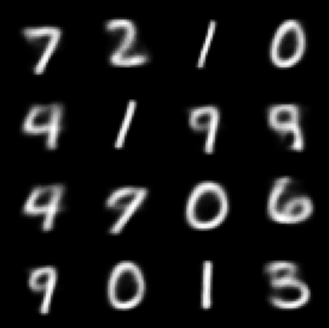

Epoch: 41, Test set ELBO: tensor([6496583.5000], grad_fn=<AddBackward0>), Kl : tensor([669262.7500], grad_fn=<AddBackward0>), recons :tensor([6429657.], grad_fn=<AddBackward0>)


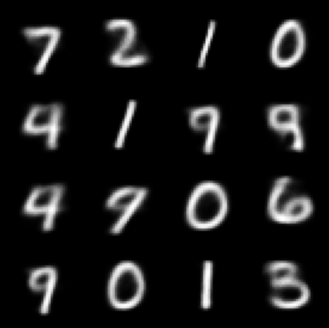

Epoch: 42, Test set ELBO: tensor([6489845.], grad_fn=<AddBackward0>), Kl : tensor([668582.0625], grad_fn=<AddBackward0>), recons :tensor([6422988.5000], grad_fn=<AddBackward0>)


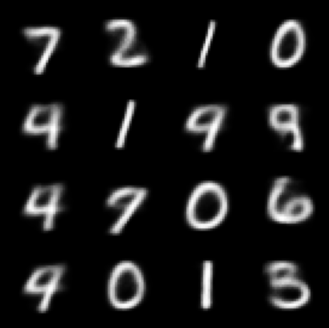

Epoch: 43, Test set ELBO: tensor([6478221.5000], grad_fn=<AddBackward0>), Kl : tensor([670458.8125], grad_fn=<AddBackward0>), recons :tensor([6411178.5000], grad_fn=<AddBackward0>)


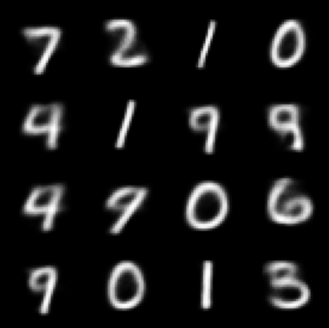

Epoch: 44, Test set ELBO: tensor([6471359.5000], grad_fn=<AddBackward0>), Kl : tensor([669100.7500], grad_fn=<AddBackward0>), recons :tensor([6404449.5000], grad_fn=<AddBackward0>)


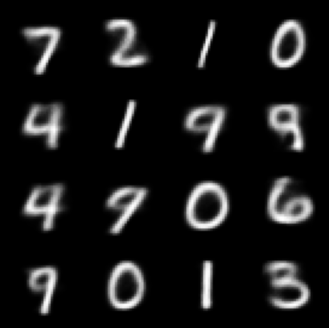

Epoch: 45, Test set ELBO: tensor([6461444.], grad_fn=<AddBackward0>), Kl : tensor([671479.7500], grad_fn=<AddBackward0>), recons :tensor([6394298.5000], grad_fn=<AddBackward0>)


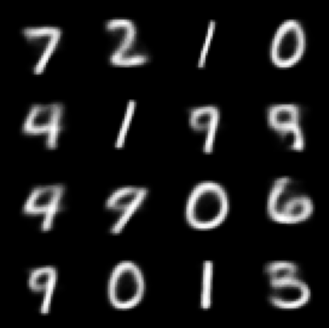

Epoch: 46, Test set ELBO: tensor([6457170.], grad_fn=<AddBackward0>), Kl : tensor([671594.1250], grad_fn=<AddBackward0>), recons :tensor([6390008.5000], grad_fn=<AddBackward0>)


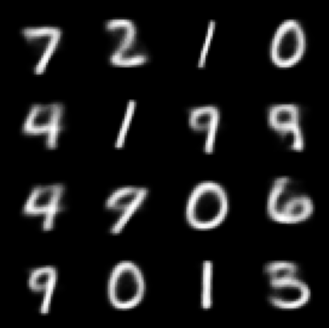

Epoch: 47, Test set ELBO: tensor([6453906.], grad_fn=<AddBackward0>), Kl : tensor([669983.1250], grad_fn=<AddBackward0>), recons :tensor([6386902.5000], grad_fn=<AddBackward0>)


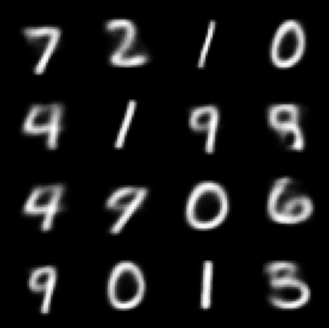

Epoch: 48, Test set ELBO: tensor([6452729.], grad_fn=<AddBackward0>), Kl : tensor([665255.3125], grad_fn=<AddBackward0>), recons :tensor([6386200.], grad_fn=<AddBackward0>)


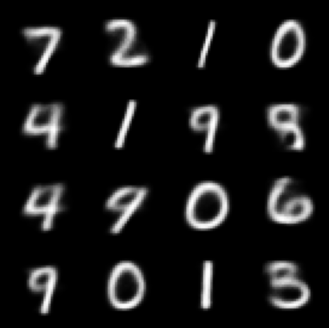

Epoch: 49, Test set ELBO: tensor([6438526.], grad_fn=<AddBackward0>), Kl : tensor([669039.5625], grad_fn=<AddBackward0>), recons :tensor([6371625.], grad_fn=<AddBackward0>)


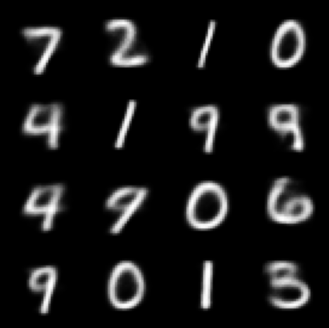

Epoch: 50, Test set ELBO: tensor([6443006.], grad_fn=<AddBackward0>), Kl : tensor([668321.0625], grad_fn=<AddBackward0>), recons :tensor([6376178.], grad_fn=<AddBackward0>)


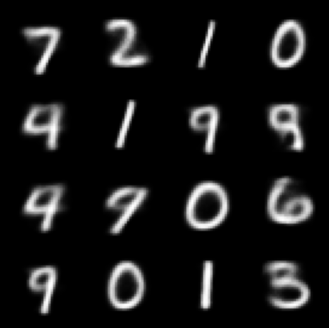

In [12]:
epochs=50
test_sample = imgs_test[0:16, :, :, :]
train_vae(model, epochs,test_sample)

We can also evaluate the latent space of our model, which should be organized (being the overall point of using a VAE instead of a common AE).

In [ ]:
path = './data/MNIST_Linear.pth'
save_model(model,path)

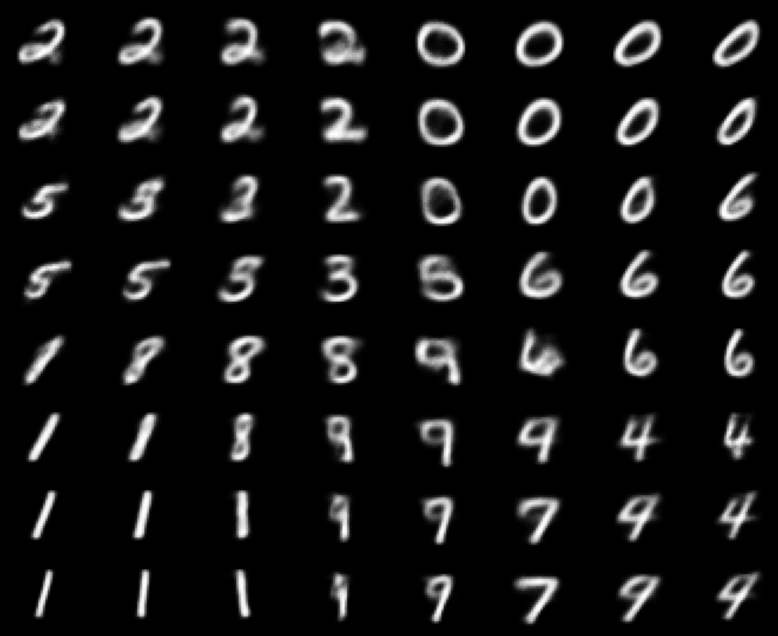

In [13]:
x = np.linspace(-3, 3, 8)
y = np.linspace(-3, 3, 8)
fig = plt.figure(figsize=(10, 8))
for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, (i * 8) + j + 1)
        final_tensor = torch.zeros(2)
        final_tensor[0] = x[i]
        final_tensor[1] = y[j]
        plt.imshow(model.decode(final_tensor).detach().reshape(28, 28), cmap='gray')
        plt.axis('off')

<a id="improve"></a>
## Improving the quality of VAEs

As we discussed in the previous section, several known issues have been reported when using the vanilla VAE implementation. We listed some of the major issues as being
1. **Blurry reconstructions.** 
2. **Posterior collapse.**
3. **Simplistic Gaussian approximation**.

Here, we discuss some recent developments that were proposed in the VAE literature and simple adjustments that can be made to (at least partly) alleviate these issues. However, note that some more advanced proposals such as PixelVAE [5](#reference1) and VQ-VAE [6](#reference1) can lead to wider increases in quality

### Reducing the bluriness of reconstructions

In this tutorial, we relied on extremely simple decoder functions, to show how we could easily define VAEs and normalizing flows together. However, the capacity of the decoder obviously directly influences the quality of the final reconstruction. Therefore, we could address this issue naively by using deep networks and of course convolutional layers as we are currently dealing with images.

First you need to construct a more complex encoder and decoder

In [17]:
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)


In [18]:

def construct_encoder_decoder_complex(nin=1, n_latent = 16, n_hidden = 64, n_params = 0, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
          nn.Conv2d(nin, n_hidden, 4, 2, padding=1), nn.ReLU(),
          nn.Conv2d(n_hidden, 128, 4, 2, padding=1), nn.ReLU(),
          nn.Flatten(),
          nn.Linear(7*7*2*n_hidden, 1024),nn.ReLU(),
          nn.Linear(1024, n_latent)
        )

    # Decoder network
    decoder = nn.Sequential(
          nn.Linear(n_latent,1024), nn.ReLU(),
          nn.Linear(1024, 7*7*2*n_hidden), nn.ReLU(),
          Reshape((2*n_hidden,7,7,)),
          nn.ConvTranspose2d(2*n_hidden, n_hidden, 4, 2, padding=1), nn.ReLU(),
          nn.ConvTranspose2d(n_hidden, nin, 4, 2, padding=1), nn.Sigmoid()
        )
    return encoder, decoder

### Preventing posterior collapse with Wasserstein-VAE-MMD (InfoVAE)

As we discussed earlier, the reason behind posterior collapse mostly relates to the KL divergence criterion (a nice intuitive explanation can be found [here](https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/). This can be mitigated by relying on a different criterion, such as regularizing the latent distribution by using the *Maximum Mean Discrepancy* (MMD) instead of the KL divergence. This model was independently proposed as the *InfoVAE* and later also as the *Wasserstein-VAE*.

Here we provide a simple implementation of the `InfoVAEMMD` class based on our previous implementations.

In [19]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [20]:
class InfoVAEMMD(VAE):
    
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(InfoVAEMMD, self).__init__(encoder, decoder, encoding_dims, latent_dims)
    
    def encode(self, x):
        z = self.encoder(x)
        return z

    def forward(self, x):
        # Encode the inputs
        z = self.encode(x)
        
        # Obtain latent samples and latent loss
        z_params, mmd = self.latent(x, z)

        # Decode the samples
        x_tilde = self.decode(z_params)
        return x_tilde.reshape(-1, 1, 28, 28), mmd    
    
    def latent(self, x, z_params):
        true_samples = torch.randn(len(x),n_latent)
        mmd = compute_mmd(true_samples, z_params)
        return z_params, mmd

### Putting it all together

Here we combine all these ideas (except for the MMD, which is not adequate as the flow definition already regularizes the latent space without the KL divergence) to perform a more advanced optimization of the dataset. Hence, we will rely on the complex encoder and decoder with gated convolutions, the multinomial loss and the normalizing flows in order to improve the overall quality of our reconstructions.

In [21]:
# Size of latent space
n_latent = 16
# Number of hidden units
n_hidden = 64
# Rely on Bernoulli or multinomial
num_classes = 1
# Number of input channel
nin = 1

######################
# YOUR CODE GOES HERE
######################

# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder_complex(nin=nin, n_latent=n_latent,n_hidden=n_hidden,n_classes= num_classes)
#encoder = encoder.to(device)
#decoder = decoder.to(device)
# Create VAE or (InfoVAEMMD - WAE) model
model_flow_p = InfoVAEMMD(encoder, decoder, n_hidden, n_latent)#.to(device)

# Create optimizer algorithm
optimizer_flow_p = torch.optim.Adam(model_flow_p.parameters(), lr=1e-4)
recons_criterion = torch.nn.MSELoss(reduction = 'sum')


# Add learning rate scheduler
#scheduler = ...
# Launch our optimization
#losses_flow_param = ...

In [22]:
def compute_loss_flow(model, x):
    model = model
    x=x
    # regularization donnée ici: https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    l = 500
    
    y_pred, mmd = model(x)
    recons_loss = recons_criterion(y_pred, x)
    
    full_loss = recons_loss + mmd * l
    return full_loss

Epoch: 1, Test set ELBO: 1317.16357421875


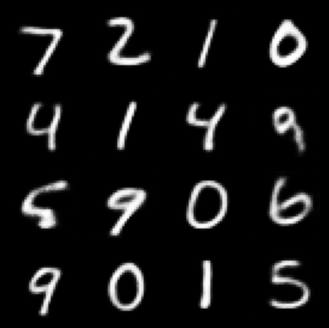

Epoch: 2, Test set ELBO: 1136.3858642578125


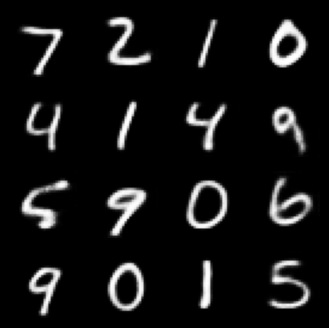

Epoch: 3, Test set ELBO: 1030.1917724609375


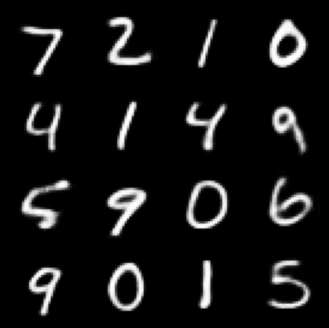

Epoch: 4, Test set ELBO: 952.7293701171875


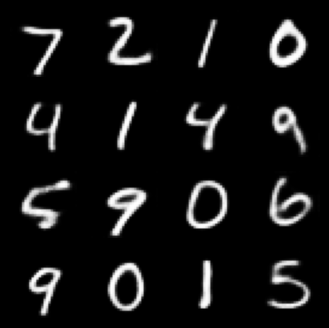

Epoch: 5, Test set ELBO: 897.0443115234375


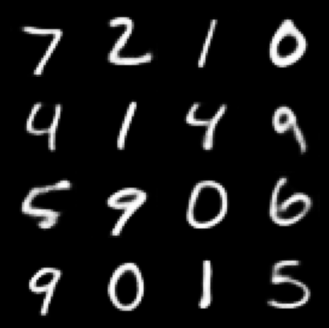

Epoch: 6, Test set ELBO: 852.679931640625


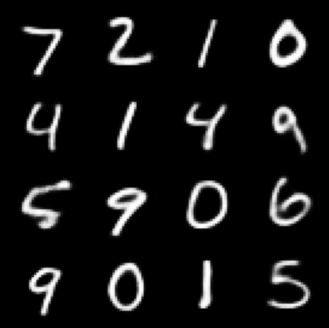

Epoch: 7, Test set ELBO: 817.4374389648438


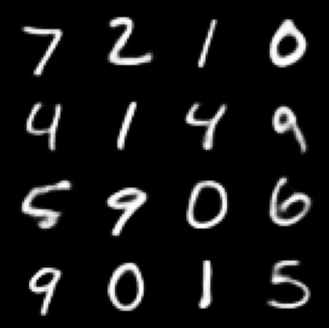

Epoch: 8, Test set ELBO: 787.2982177734375


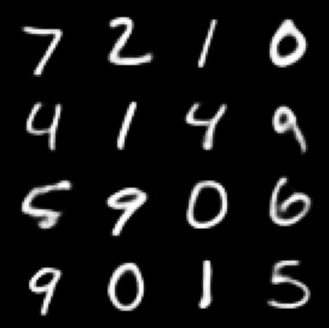

KeyboardInterrupt: 

In [24]:
# Launch our optimization
epochs=50
test_sample = imgs_test[0:16, :, :, :]
losses_flow = []

for epoch in range(1, epochs + 1):
    full_loss_flow = 0

    # Forward pass: compute predicted y by passing x to the model.
    for i, (x, _) in enumerate(train_loader):

        # Pass model and data to the device (GPU or CPU)
        model_flow_p = model_flow_p
        x = x        

        # forward the model
        y_pred, mmd = model_flow_p(x)
    
        # compute loss
        loss_flow = compute_loss_flow(model_flow_p, x)
    
        # Before the backward pass, zero all of the network gradients
        optimizer_flow_p.zero_grad()
   
        # Backward pass: compute gradient of the loss with respect to parameters
        loss_flow.backward()
    
        # Calling the step function to update the parameters
        optimizer_flow_p.step()

    print('Epoch: {}, Test set ELBO: {}'.format(epoch, loss_flow))
    losses_flow.append(loss_flow.detach().cpu().numpy())
    generate_and_save_images(model_flow_p, epoch, test_sample)

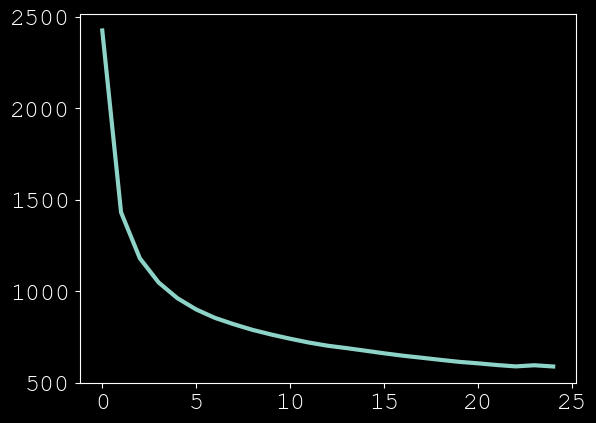

In [ ]:
# Plot final loss
plt.figure()
plt.plot(losses_flow)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 16x1024)

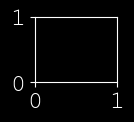

In [25]:
x = np.linspace(-3, 3, 8)
y = np.linspace(-3, 3, 8)
fig = plt.figure(figsize=(10, 8))
for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, (i * 8) + j + 1)
        final_tensor = torch.zeros(2)
        final_tensor[0] = x[i]
        final_tensor[1] = y[j]
        plt.imshow(model_flow_p.decode(final_tensor).detach().reshape(28, 28), cmap='gray')
        plt.axis('off')

In [27]:
torch.save(model_flow_p.state_dict(), './data/MNIST_mmd.pt')

In [30]:
load_model("./data/MNIST_mmd.pt")

*NB*: It seems that the multinomial version have a hard time converging. Although I only let this run for 200 epochs and only for a subsampling of 5000 examples, it might need more time, but this might also come from a mistake somewhere in my code ... If you spot something odd please let me know :)

### References

<a id="reference1"></a>
[1] Rezende, Danilo Jimenez, and Shakir Mohamed. "Variational inference with normalizing flows." _arXiv preprint arXiv:1505.05770_ (2015). [link](http://arxiv.org/pdf/1505.05770)

[2] Kingma, Diederik P., Tim Salimans, and Max Welling. "Improving Variational Inference with Inverse Autoregressive Flow." _arXiv preprint arXiv:1606.04934_ (2016). [link](https://arxiv.org/abs/1606.04934)

[3] Kingma, D. P., & Welling, M. Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114. (2013). [link](https://arxiv.org/pdf/1312.6114)

[4] Rezende, D. J., Mohamed, S., & Wierstra, D. Stochastic backpropagation and approximate inference in deep generative models. arXiv preprint arXiv:1401.4082. (2014). [link](https://arxiv.org/pdf/1401.4082)

[5] Gulrajani, I., Kumar, K., Ahmed, F., Taiga, A. A., Visin, F., Vazquez, D., & Courville, A. (2016). Pixelvae: A latent variable model for natural images. arXiv preprint arXiv:1611.05013. [link](https://arxiv.org/pdf/1611.05013)

[6] Van den Oord, A., & Vinyals, O. (2017). Neural discrete representation learning. In NIPS 2017 (pp. 6306-6315). [link](http://papers.nips.cc/paper/7210-neural-discrete-representation-learning.pdf)

### Inspirations and resources

https://blog.evjang.com/2018/01/nf1.html  
https://github.com/ex4sperans/variational-inference-with-normalizing-flows  
https://akosiorek.github.io/ml/2018/04/03/norm_flows.html  
https://github.com/abdulfatir/normalizing-flows  
https://github.com/riannevdberg/sylvester-flows